In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly as py
from fa2 import ForceAtlas2
import matplotlib.colors as pltcolors

In [2]:
G = nx.read_gpickle('postive_books_graph.pcl')

d = dict(G.degree)
d_between = dict(nx.betweenness_centrality(G))
d_eigen = dict(nx.eigenvector_centrality(G))

total = pd.DataFrame(data = {'Name' : list(d.keys()), 
                             'Degree' : list(d.values()),
                             'Betweenness_centrality' : list(d_between.values()),
                             'Eigenvector_centrality' : list(d_eigen.values())})

In [3]:
print(f"The network consists of {nx.number_of_nodes(G)} nodes and {nx.number_of_edges(G)} edges.")

The network consists of 1917 nodes and 9898 edges.


# Plotting network

In [29]:
colors, pos = set_generic_node_attributes(G, 'genre', scaling=0.1, grav=10, log=False,  n_f2_iter=2000)

In [32]:
edge_trace = edges_to_plot(G, pos)

In [33]:
degree_node_trace = nodes_to_plot(G, 'Degree', colors)
G_degree = make_fig(edge_trace, degree_node_trace, 'Network with nodesize proportional to degree')

Getting node coordinates
Setting hover text for nodes
Creating figure


In [34]:
py.offline.plot(G_degree, filename = 'Plots/G_degree.html', auto_open=True)

'Plots/G_degree.html'

In [35]:
between_node_trace = nodes_to_plot(G, 'Betweenness_centrality', colors)
G_between = make_fig(edge_trace, between_node_trace, 'Network with nodesize proportional to betweenness-centrality')

Getting node coordinates
Setting hover text for nodes
Creating figure


In [36]:
py.offline.plot(G_between, filename = 'Plots/G_betweeen.html', auto_open=True)

'Plots/G_betweeen.html'

In [37]:
eigen_node_trace = nodes_to_plot(G, 'Eigenvector_centrality', colors)
G_eigen = make_fig(edge_trace, eigen_node_trace, 'Network with nodesize proportional to eigenvector-centrality')

Getting node coordinates
Setting hover text for nodes
Creating figure


In [38]:
py.offline.plot(G_eigen, filename = 'Plots/G_eigen.html', auto_open=True)

'Plots/G_eigen.html'

# Functions

In [5]:
def set_generic_node_attributes(G, color_by, scaling=1, grav=1, log=False,  n_f2_iter=2000):
    '''
    Function to get colors given a given group, and initialise the Force Atalas algorithm. 
    
    Parameters:
    G: networkx graph with attribute color_by
    color_by: attribute in graph G that graph should be colored by
    scaling: hyperparameter for Force Atlas algorithm. By default set to 1
    grav: gravity hyperparameter for Force Atlas algorithm. By default set to 1
    log: if True progress bar of tuning of Force Atlas will be displayed
    n_f2_iter: number of iterations for Force Atlas algorithm. By default set to 2000
    
    Return:
    colors: map for color of node in graph
    pos: positions for nodes in graph
    '''
    
    # Getting mapping of colors for nodes to seperate on genre:
    groups = set(nx.get_node_attributes(G,color_by).values())
    colors_tmp = list(pltcolors._colors_full_map.values())[0:len(groups)]
    cmap = dict(zip(groups, colors_tmp))
    nodes = G.nodes()
    colors = [cmap.get(G.node[n][color_by]) for n in nodes]

    #Defining positions using Force Atlas algorithm
    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=scaling,
                        strongGravityMode=False,
                        gravity=grav,

                        # Log
                        verbose=log)
    
    pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=n_f2_iter)
    
    return colors, pos

In [ ]:
def make_plot(G, d_measure, title, colors = 0):
    '''
    Function generating an interactive plot of network.
    
    INPUT:
    - G: Graph as networkx graph
    - d_measure: Measure defining size of nodes as string (possible values: 'Degree', 'Betweenness_centrality', 'Eigenvector_centrality')
    - title: Title on plot as string
    - Colors: Mapping of colors (Should not be set )
    '''
    
    
    
    if d_measure == 'Degree':
        add = 50
        scale = 80
    elif d_measure == 'Betweenness_centrality':
        add = 0.001
        scale = 100 
    else:
        add = 0
        scale = 25
    
    # Get coordinates of edges
    print("Getting edge coordinates")
    edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
    for edge in G.edges():
        x0, y0 = pos.get(edge[0])
        x1, y1 = pos.get(edge[1])
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    
    #Get coordinates of nodes
    print("Getting node coordinates")
    node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=colors,
        size=((total[d_measure]+add)/total[d_measure].max())*scale,
        line=dict(width=2)))
    for node in G.nodes():
        x, y = pos.get(node)
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    
    # Get hover text for nodes
    print("Setting hover text for nodes")
    for node, adjacencies in enumerate(G.adjacency()):
        node_info = 'Name: ' + str(adjacencies[0]) + '<br># of ingoing connections: '+str(len(adjacencies[1]))
        node_trace['text']+=tuple([node_info])
    
    # Create figures
    print("Creating figure")
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont=dict(size=20),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor = 'white'))
    return fig

In [17]:
def edges_to_plot(G, pos):
    '''Function that gets the position for all the edges'''
    edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
    for edge in G.edges():
        x0, y0 = pos.get(edge[0])
        x1, y1 = pos.get(edge[1])
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    return edge_trace

In [16]:
def nodes_to_plot(G, d_measure, colors):
    '''Function that gets the position for all the nodes and adds hover text'''
    if d_measure == 'Degree':
        add = 50
        scale = 80
    elif d_measure == 'Betweenness_centrality':
        add = 0.001
        scale = 100 
    else:
        add = 0
        scale = 25
        
    #Get coordinates of nodes
    print("Getting node coordinates")
    node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=colors,
        size=((total[d_measure]+add)/total[d_measure].max())*scale,
        line=dict(width=2)))
    for node in G.nodes():
        x, y = pos.get(node)
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    
    # Get hover text for nodes
    print("Setting hover text for nodes")
    for node, adjacencies in enumerate(G.adjacency()):
        node_info = 'Name: ' + str(adjacencies[0]) + '<br># of ingoing connections: '+str(len(adjacencies[1]))
        node_trace['text']+=tuple([node_info])
    
    return node_trace

In [15]:
def make_fig(edge_trace, node_trace, title):
    '''Function that creates a figure based on edge- and node-trace'''
    # Create figures
    print("Creating figure")
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont=dict(size=20),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor = 'white'))
    return fig

In [26]:
def make_fig2(node_trace, title):
    '''Function that creates a figure based on edge- and node-trace'''
    # Create figures
    print("Creating figure")
    fig = go.Figure(data=[node_trace],
             layout=go.Layout(
                title=title,
                titlefont=dict(size=20),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor = 'white'))
    return fig

In [17]:
test.head(1)

,title,author,genre,rating,rating_count,related,review
0,To Kill a Mockingbird,Harper Lee,Classics,4.27,4058926,"['Harry Potter and the Deathly Hallows', 'Lord...","[[""\n \n Why is it when I ..."


In [26]:
test.rating = pd.to_numeric(test.rating)
test.rating_count = pd.to_numeric(test.rating_count)

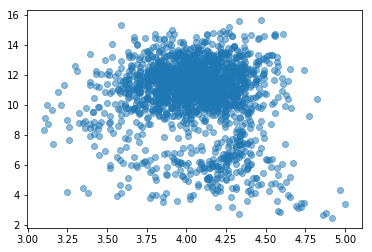

In [33]:
plt.scatter(test.rating, np.log(test.rating_count), alpha=0.5)
plt.show()

0.2540602128699682
0.05976603454608498


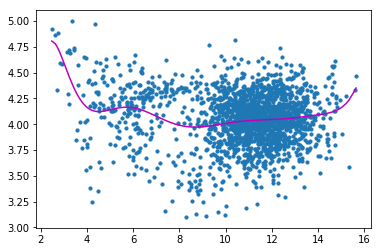

In [42]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures



# transforming the data to include another axis

x = np.log(test.rating_count)[:, np.newaxis]

y = test.rating[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=10)

x_poly = polynomial_features.fit_transform(x)



model = LinearRegression()

model.fit(x_poly, y)

y_poly_pred = model.predict(x_poly)



rmse = np.sqrt(mean_squared_error(y,y_poly_pred))

r2 = r2_score(y,y_poly_pred)

print(rmse)

print(r2)



plt.scatter(np.log(test.rating_count), test.rating, s=10)

# sort the values of x before line plot

sort_axis = operator.itemgetter(0)

sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)

x, y_poly_pred = zip(*sorted_zip)

plt.plot(x, y_poly_pred, color='m')

plt.show()